# One EQS layer for Simple sources

In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
import xarray as xr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import synthetics

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Create simple synthetic

Set the data coordinates and field direction.

N data: 92046


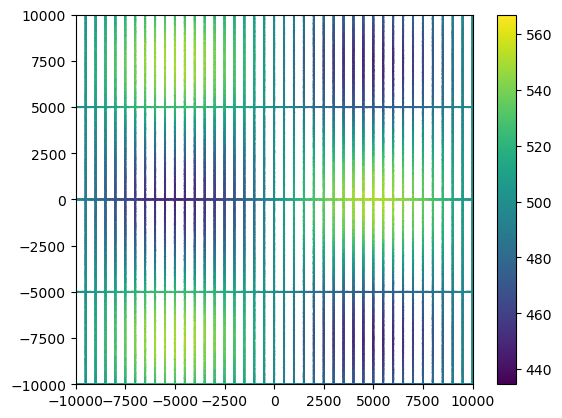

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)
field_direction = np.array([hm.magnetic_angles_to_vec(1, 84, 120)]).T

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=50, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

Create the dipole source model.

In [4]:
source_direction = [70, 60] # [inc, dec]
source_coords, dipole_moments = synthetics.simple_synthetic(
    dyke1=source_direction,
    dyke2=source_direction,
    point1=source_direction,
    point2=source_direction,
    point3=source_direction,
    point4=source_direction,
    regional=source_direction,
)

b = eqs.dipole_magnetic(
    coordinates,
    source_coords,
    dipole_moments
)
tfa = eqs.contaminate(
    eqs.total_field_anomaly(b, field_direction),
    standard_deviation=50,
    random_state=42,
)
bnorm = eqs.magnetic_field_norm(b)

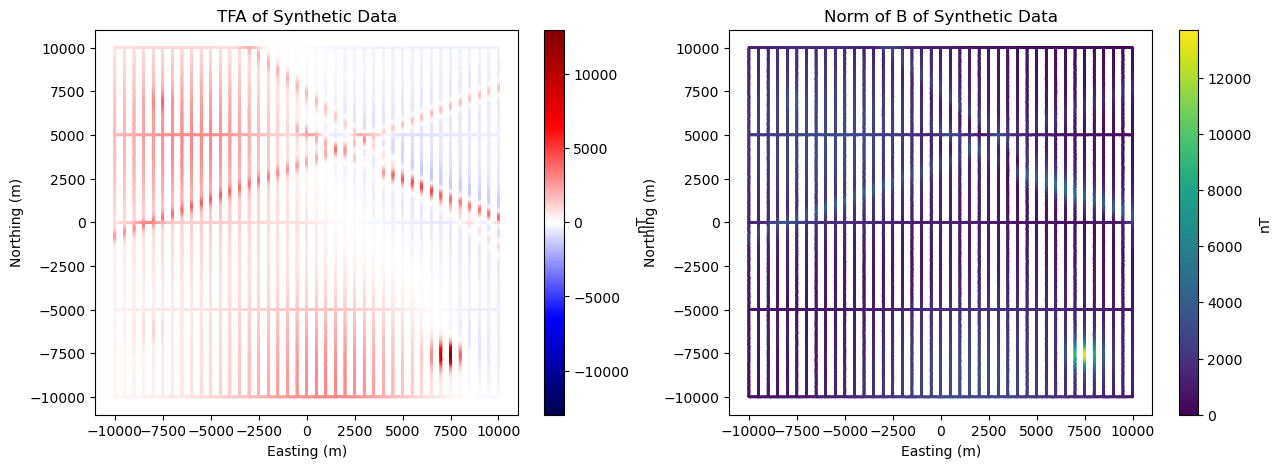

In [5]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis", s=0.5, vmin=0, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit one layer of EQS

In [6]:
dampings = [1e-4, 1e-2, 1, 1e2, 1e4]
depths = [900, 1e3, 1.5e3, 2e3]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 20


In [ ]:
%%time
kfold = vd.BlockKFold(
    spacing=1e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=500, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 0.0001, 'depth': 900}
{'damping': 0.0001, 'depth': 1000.0}
{'damping': 0.0001, 'depth': 1500.0}
{'damping': 0.0001, 'depth': 2000.0}
{'damping': 0.01, 'depth': 900}
{'damping': 0.01, 'depth': 1000.0}
{'damping': 0.01, 'depth': 1500.0}
{'damping': 0.01, 'depth': 2000.0}
{'damping': 1, 'depth': 900}
{'damping': 1, 'depth': 1000.0}
{'damping': 1, 'depth': 1500.0}
{'damping': 1, 'depth': 2000.0}
{'damping': 100.0, 'depth': 900}
{'damping': 100.0, 'depth': 1000.0}
{'damping': 100.0, 'depth': 1500.0}
{'damping': 100.0, 'depth': 2000.0}
{'damping': 10000.0, 'depth': 900}
{'damping': 10000.0, 'depth': 1000.0}
{'damping': 10000.0, 'depth': 1500.0}
{'damping': 10000.0, 'depth': 2000.0}
CPU times: user 1h 24min 50s, sys: 9.73 s, total: 1h 25min
Wall time: 6min 24s


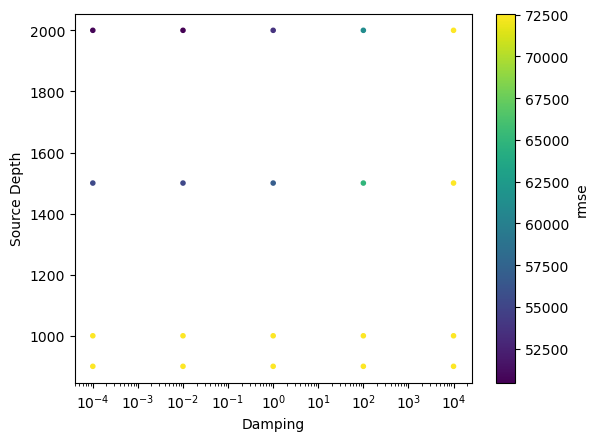

In [8]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [9]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 0.01, 'depth': 2000.0}

In [10]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=500, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -1499.3546174391745
window size: 4669.642453391388
CPU times: user 47.1 s, sys: 88.7 ms, total: 47.1 s
Wall time: 3.99 s


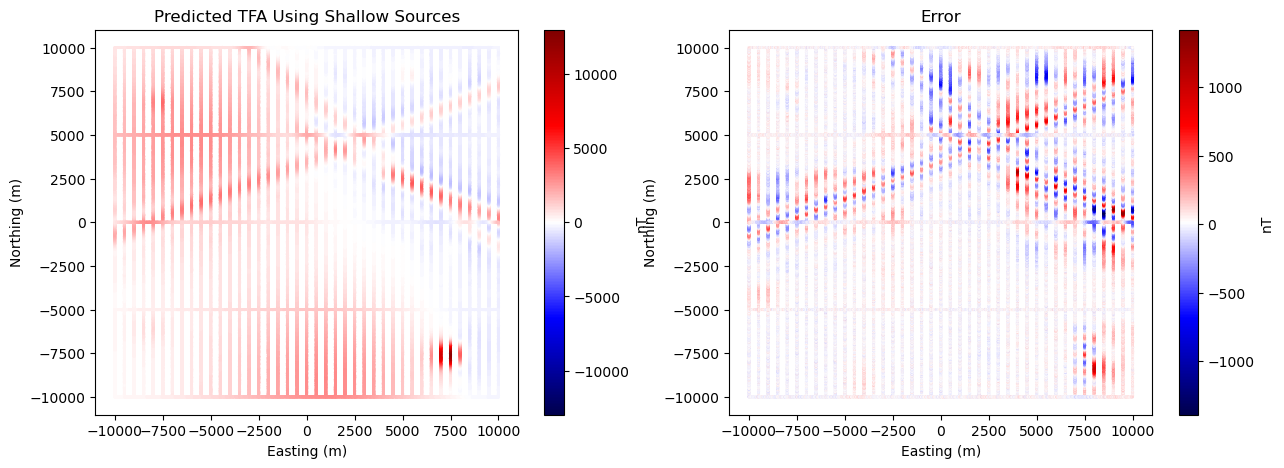

In [11]:
tfa_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_predicted, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa - tfa_predicted, cmap="seismic", s=1)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Norm of B prediction

In [12]:
grid_coords = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_b = eqs.dipole_magnetic(grid_coords, source_coords, dipole_moments)
predicted_b = eqs_shallow.predict(grid_coords)

true_tfa = eqs.total_field_anomaly(true_b, field_direction)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

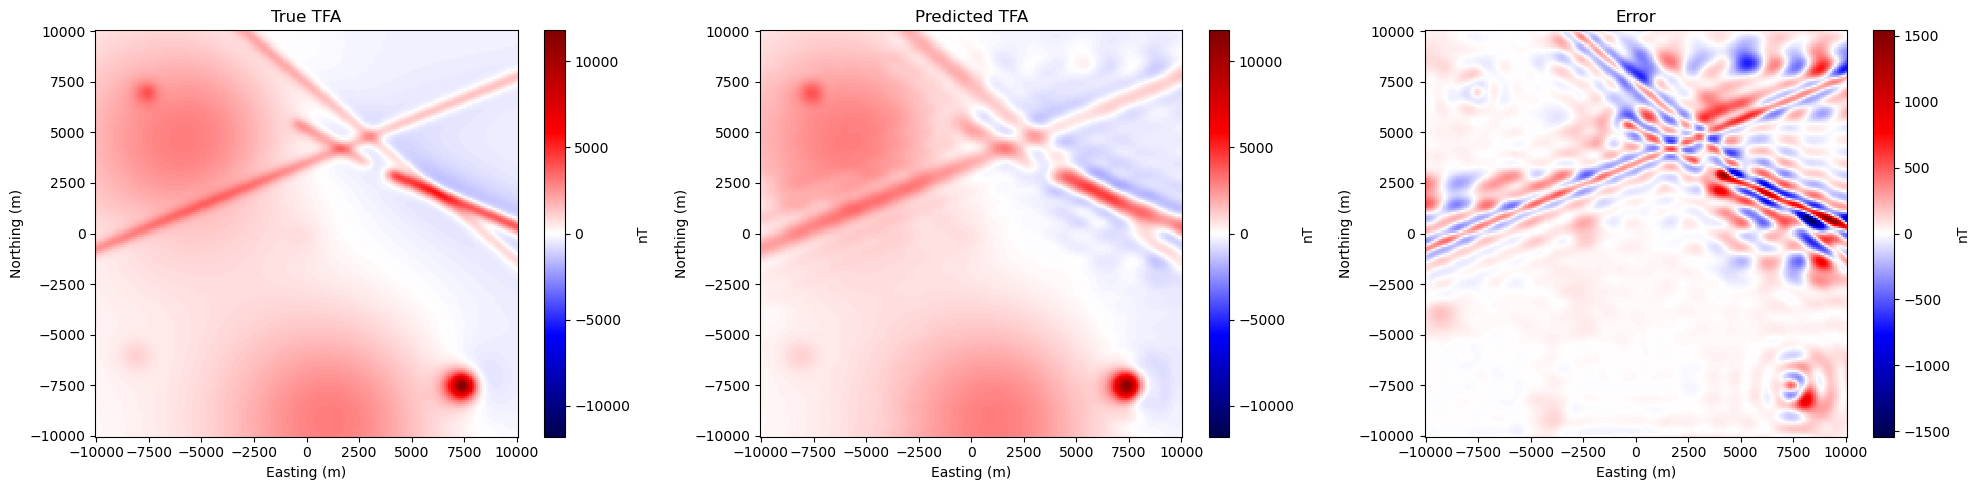

In [13]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coords[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coords[:2], predicted_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coords[:2], error_tfa, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

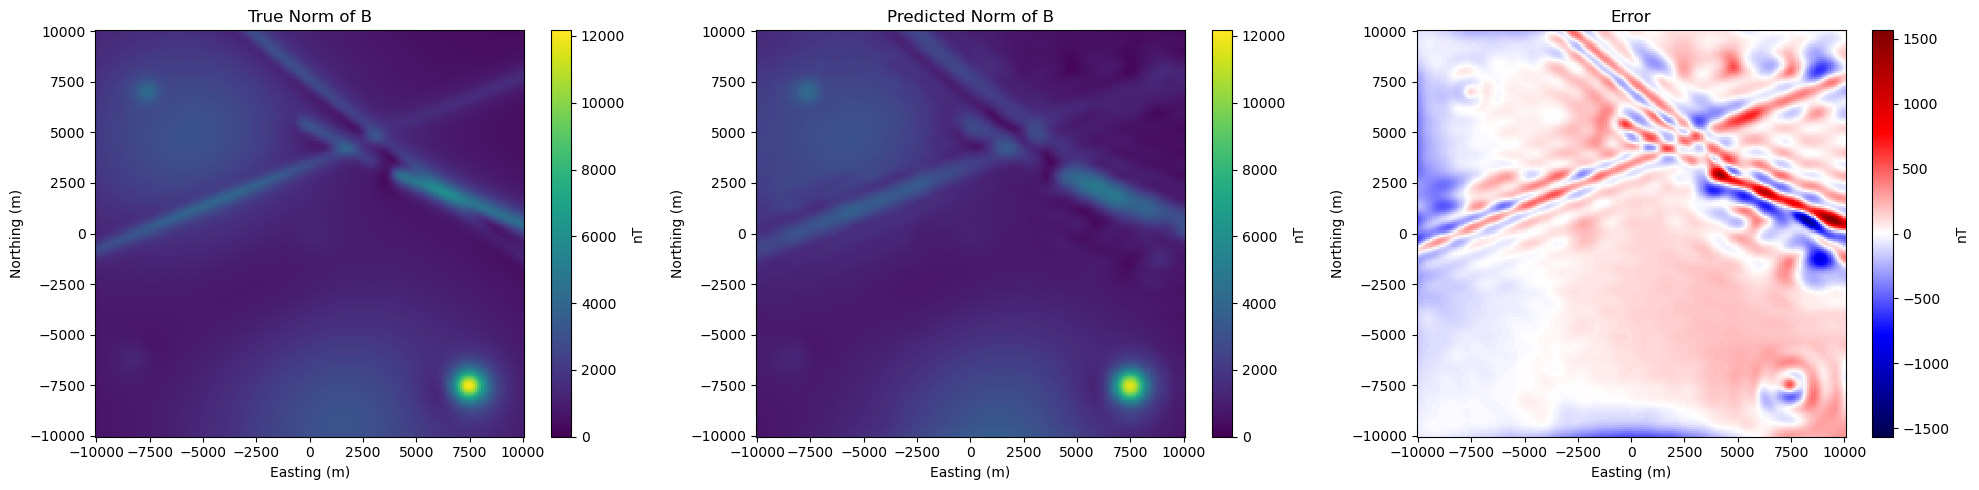

In [14]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coords[:2], true_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coords[:2], predicted_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coords[:2], error_norm_of_b, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()